In [1]:
import numpy as np
from numpy import pi as pi
import scipy.signal as sg
import scipy.io 
import matplotlib.pyplot as plt
import cmocean
from mpl_toolkits.axes_grid1 import ImageGrid
from mcsm_benchmarks.SignalBank import SignalBank
from src.utilities.spatstats_utils import compute_rank_envelope_test, generate_white_noise_zeros_pp
from src.utilities.utilstf import get_round_window, get_spectrogram, find_zeros_of_spectrogram, add_snr

In [2]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

0.0
0.0
15.0
30.0


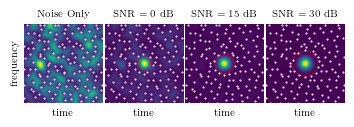

In [6]:
# rng
np.random.seed(1000) 

# signal parameters
SNRin = [0, 0, 15, 30]
N = 2**8
Nfft = 2*N
T = np.sqrt(Nfft)

logon = lambda tloc,floc:  np.exp(-pi*(np.arange(N)-tloc)**2/T**2)*np.exp(2j*pi*floc*np.arange(N))
x = np.real(logon(N//2, 0.25))
x /= np.sum(x**2)
noise = np.random.randn(*x.shape)
noise /= np.linalg.norm(noise)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

# fig, axs = plt.subplots(1,3, sharey='row')
fig = plt.figure()
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(1,4),  # creates 2x2 grid of axes
                axes_pad=0.025,  # pad between axes in inch.
                )

kk = 0

for snr,axs in zip(SNRin,grid):
    h = np.linalg.norm(x)*10**(-snr/20)
    xnoise = x + h*noise

    print(20*np.log10(np.linalg.norm(x)/np.linalg.norm(h*noise)))

    if kk==0:
        xnoise = noise

    S, stft = get_spectrogram(xnoise)
    stft = stft[0:N+1,:]
    ceros = find_zeros_of_spectrogram(S)
    axs.imshow(abs(stft), origin='lower')
    # axs.imshow(np.log(S), origin='lower', cmap=cmocean.cm.deep)
    axs.plot(ceros[:,1],ceros[:,0],'wo', markersize=0.5)
    
    # Remove ticks labels
    axs.tick_params(axis='both', which='both', bottom=False, top=False, 
                    labelbottom=False, right=False, left=False, labelleft=False)
    
    # Print the circle limiting the signal domain.
    radius = -2*pi*np.log(np.std(h*noise))
    if kk==0:
        radius=0

    circle = plt.Circle((N//2, N//2), radius*0.9, linewidth = 0.5, linestyle='--', color='r', fill=False)
    axs.add_patch(circle)
    axs.set_title(r"SNR $={}$ dB".format(snr), fontsize=7)
    if kk==0:
        axs.set_title(r"Noise Only", fontsize=7)
    # axs.axis('off')
    
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    axs.spines['left'].set_visible(False)

    # Label the axis.
    axs.set_ylabel('frequency', fontsize=7)
    axs.set_xlabel('time', fontsize=7)

    kk += 1

# # Keep outer subplots' labels.
# for ax in axs.flat:
#     ax.label_outer()    

set_size(3.2,1, ax=fig)
fig.savefig('figures/shrinking_domains.pdf', dpi=900, transparent=False, bbox_inches='tight', pad_inches=0.001)

# plt.tight_layout()
plt.show()